# Local Expansion Kmeans Parallel version
___

In this notebook, we have enhanced the performance by modifying our algorithms to perform tests for determining the optimal number of clusters in parallel. This adjustment ensures significantly improved efficiency and speed in our cluster analysis.

In [1]:
from utils.utils import *
from utils.visualization import *
from utils.communities_network import *
from utils.iterative_greedy_algorithm import IG
from utils.kmeans import *
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import time
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor
import warnings
import matplotlib.pyplot as plt
import pandas as pd
from netgraph import Graph
warnings.filterwarnings("ignore")

In [2]:
def kmeans(G, D, K, D_transformed , A, metric):

    for i in tqdm(range(1) , desc = f"K = {K}"):
        initial_seeds = local_expension(G, D, K)

        communities, labels = kmeans_clustering(
            D_transformed, K, D_transformed[initial_seeds])

        # Calculate the similarity-based modularity Qs
        if metric == "Mod":
            Qs = calculate_modularity(G, communities)
        elif metric == "QSim":
            Qs = calculate_Q_Sim(A, communities)

    return Qs , communities,labels, K

In [3]:

def local_expansion_kmeans_parallel(G: nx.Graph, A: np.ndarray, Kmin: int, Kmax: int, metric="Mod") -> list:
    """
    This function implements the local expansion k-means algorithm.
    It takes a weighted adjacency matrix A, minimum number of clusters Kmin, and maximum number of clusters Kmax.
    It returns the community set Cmax.
    """

    # Calculate the similarity matrix S using the weighted adjacency matrix A
    S = similarity_matrix(A)

    # Calculate the distance matrix D using S
    D = distance_matrix(S)

    D_transformed = PCA_reduction(D)

    Cmax = []
    Qmax = -1
    Kbest = Kmin
    labelsBest = []

    trace = []

    with ThreadPoolExecutor() as executor:
        
        futures = [executor.submit(kmeans, G, D, K, D_transformed, A, metric) for K in (range(Kmin, Kmax + 1))]

        for p,future in enumerate(futures):
            Qs, communities, labels, K = future.result()

            if Qs > Qmax:
                Qmax = Qs
                Cmax = communities
                Kbest = K
                labelsBest = labels
    
    return Cmax, Qmax, Kbest, labelsBest, trace


In [4]:

file_path = 'data/synth/LFR/0.40/network.dat'
G = nx.read_edgelist(file_path, nodetype=int)
original_nodes = list(G.nodes())
mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, mapping)
adj_matrix = nx.to_numpy_array(G)
adj_matrix.shape[0]


true_communities = read_community_labels_file_synth(
    "data/synth/LFR/0.40/community.dat")

In [5]:
Cmax, Qmax, Kbest, labelsBest, trace = local_expansion_kmeans_parallel(G, adj_matrix, 2, 10)

K = 5:   0%|          | 0/1 [00:00<?, ?it/s]

K = 6:   0%|          | 0/1 [00:00<?, ?it/s]

K = 8:   0%|          | 0/1 [00:00<?, ?it/s]

K = 3:   0%|          | 0/1 [00:00<?, ?it/s]

K = 4:   0%|          | 0/1 [00:00<?, ?it/s]

K = 7:   0%|          | 0/1 [00:00<?, ?it/s]

K = 9:   0%|          | 0/1 [00:00<?, ?it/s]

K = 2:   0%|          | 0/1 [00:00<?, ?it/s]

K = 10:   0%|          | 0/1 [00:00<?, ?it/s]

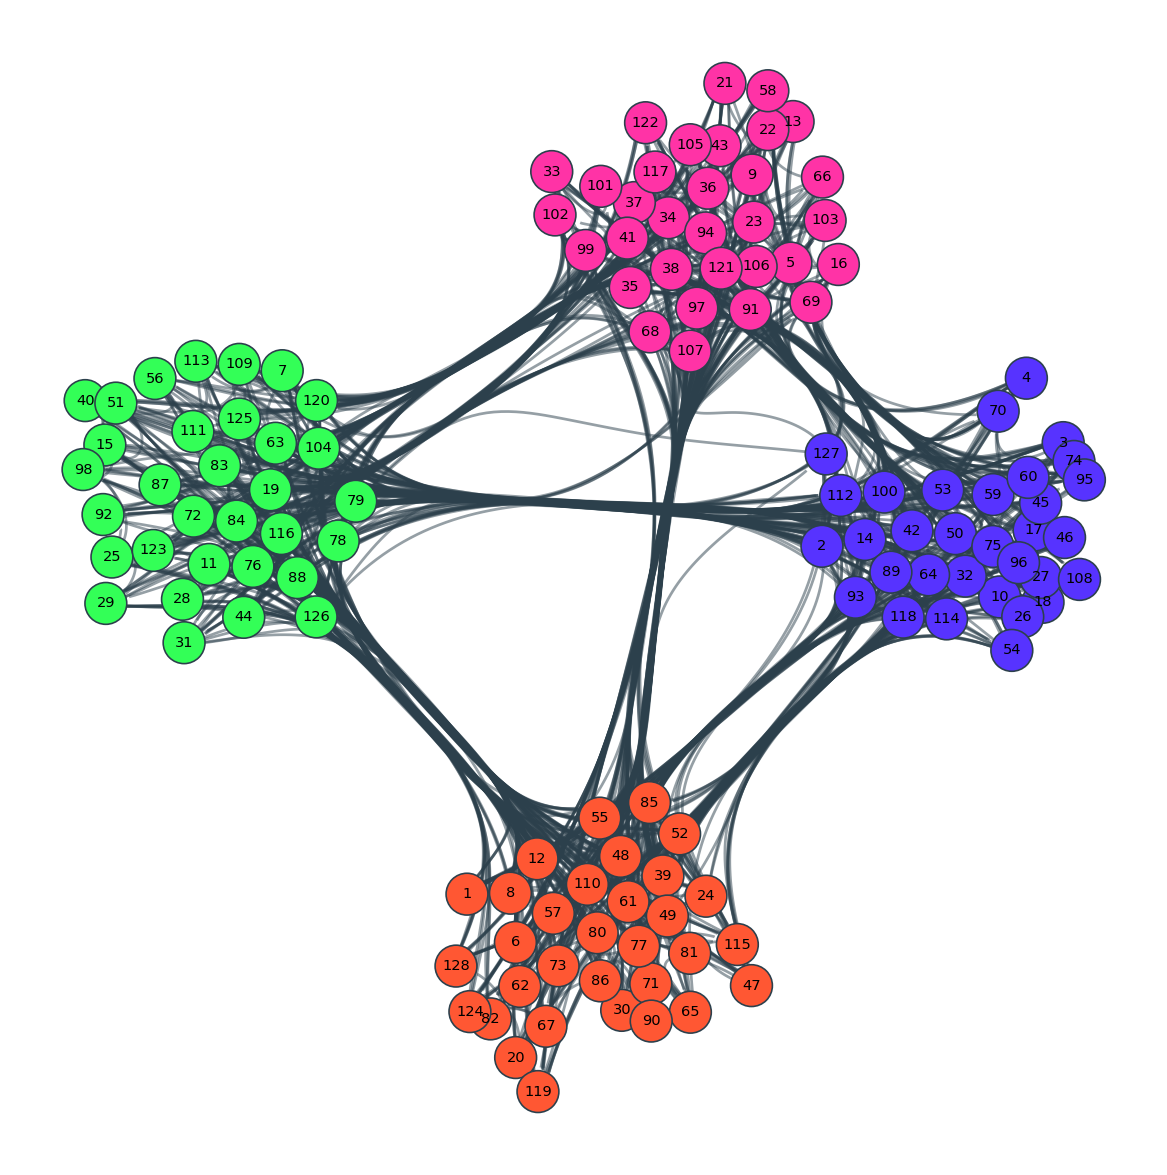

In [6]:
partion = {node-1: comm-1 for node,
           comm in communities_to_labels(G, Cmax, original_nodes)}
node_labels = {node: f"{node+1}" for node, comm in partion.items()}

community_to_color = {
    0: "#FF5733",
    1: "#33FF57",
    2: "#5733FF",
    3: "#FF33A6",
    4: "#A633FF",
    5: "#33A6FF",
    6: "#FFD133",
    7: "#33FFD1",
    8: "#D133FF",
    9: "#FFE133",
    10: "#33FFE1"

}

node_color = {node: community_to_color[community_id]
              for node, community_id in partion.items()}


plt.figure(figsize=(15, 15))
Graph(
    G,
    node_color=node_color, node_edge_width=0.3, edge_alpha=.5, edge_width=.5,
    node_layout='community', node_layout_kwargs=dict(node_to_community=partion),
    edge_layout='bundled', edge_layout_kwargs=dict(k=2000), node_labels=node_labels, node_size=4, scale=(1.6, 1.6)
)
plt.show()